In [176]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

# 期待値と分散共分散行列の準備
mean = np.array([0, 0])
cov = np.array([[1, 0.8], [0.8, 1]])

# 生成
data_1 = np.random.multivariate_normal(mean, cov, size=200)
x=data_1[:,0].reshape(200,1)
z=data_1[:,1].reshape(200,1)

# np.random.randn()は、平均0、分散1（標準偏差1）の正規分布（標準正規分布）に従う乱数を返す。
e = np.random.randn(200,1)

y = 1.5*x+1.1*z+e
y = y.flatten()
# データ型の確認
print(x.shape)
print(y.shape)

(200, 1)
(200,)


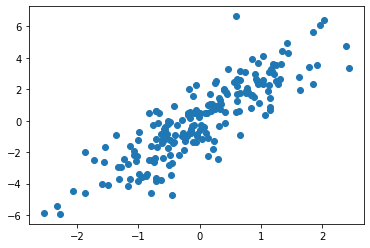

In [177]:
import matplotlib.pyplot as plt
plt.scatter(x,y)

In [178]:
from sklearn.linear_model import LinearRegression
lg = LinearRegression()
lg.fit(x,y)

LinearRegression()

In [179]:
print(lg.coef_)
print(lg.intercept_)

[2.28274475]
0.04565511303628118


もともとのxの係数が1.5だったが、交絡因子zの影響が計測できないので、xの係数が2.4と本来より大きな値になっている。=xの因果効果の推定値が本来より高く出てしまっている。これを層別解析により抑えることを試みる。

手順  
1.交絡因子zを離散化(binning)して「交絡因子の値を固定」する。  
2.再度回帰を学習させ、分散の重みづけ平均で回帰係数を推定する。

1.交絡因子zを離散化(binning)して「交絡因子の値を固定」する。  

In [180]:
x = x.flatten()
z = z.flatten()
df = pd.DataFrame([x,y,z],index=['x','y','z']).T

bins = [np.percentile(df['z'],0),np.percentile(df['z'],25),np.percentile(df['z'],50),np.percentile(df['z'],75),np.percentile(df['z'],100)]
# 指定した境界（0~45まで9等分、それ以上は一つのbinに）でビニングした特徴量
# 範囲の左端（この場合 0 を範囲内に含めるために、bins の初めの要素を -1 に
# 範囲の右端は、指定要素の値を含むので 100 で OK 
df['z_cat'] = pd.cut(df['z'],
                bins=bins,
                labels=[i for i in range(0, 4)]
                )



2.再度回帰を学習させ、分散の重みづけ平均で回帰係数を推定する。

In [226]:
# やたら煩雑になってしまったが、やっていることは交絡因子を固定した状態でそれぞれの
# 係数と切片を出しただけ

df_d = {}
for i in range(df['z_cat'].nunique()):
    df_d[i] = df.query(f"z_cat== {i}")
    
coef = []
stdl = []
intercept = []

for i in range(df['z_cat'].nunique()):
    x = df_d[i]['x'].values.reshape(-1, 1)
    y = df_d[i]['y']
    std = np.(x)
    lg = LinearRegression()
    lg.fit(x,y)

    coef.append(float(lg.coef_))
    intercept.append(lg.intercept_)

print(coef)
print(intercept)

[1.452835094281303, 1.4283949975298484, 1.4267717106582625, 1.586894648586023]
[-1.336908046490705, -0.24587581189723778, 0.48813801877645613, 1.226853291957387]


In [155]:
statsmodel使えば回帰係数の分散もわかりそうなので明日やる

pandas.core.frame.DataFrame